In [ ]:
import sys
import os
from pathlib import Path

sys.path.append(os.path.abspath(".."))

import torch
import numpy as np
import umap
import matplotlib.pyplot as plt


from utils.data import (
    download_mnist_data,
    get_mnist_image_np_arrays,
    get_mnnist_labels_np_arrays,
    UMAPImageDataset,
)
from utils.autoencoder import MNISTAutoencoder
from utils.loss import UMAPAutoencoderLoss
from utils.train_functions import (
    train_autoencoder,
    train_autoencoder_with_umap,
    test_autoencoder_reconstruction,
    test_autoencoder_umap_embedding,
)

# Load MNIST images

In [ ]:
# Skips downloading if data is already present
download_mnist_data()

In [ ]:
train_images, test_images = get_mnist_image_np_arrays()

# Labels for visualization purposes
train_labels, test_labels = get_mnnist_labels_np_arrays()

# UMAP embeddings

## Generate  & save embeddings

In [71]:
# COMMENTED OUT TO AVOID REGENERATING UMAP EMBEDDINGS
# Remove comments to regenerate UMAP embeddings

embedding_dim = 2

full_images = np.concatenate([train_images, test_images], axis=0)
flat_full_images = full_images.reshape(full_images.shape[0], -1)

flat_train_images = train_images.reshape(train_images.shape[0], -1)
reducer = umap.UMAP(n_components=embedding_dim)
full_embeddings = reducer.fit_transform(flat_full_images)

train_embeddings = full_embeddings[: len(train_images)]
test_embeddings = full_embeddings[len(train_images) :]

# Save full embeddings to a file
project_dir = Path("..").resolve()
embeddings_file = (
    project_dir
    / "data"
    / "mnist"
    / "umap_embeddings"
    / f"embeddings_d{embedding_dim}.npy"
)
embeddings_file.parent.mkdir(parents=True, exist_ok=True)
np.save(embeddings_file, full_embeddings)


## Load embeddings (if already saved)

In [6]:
embedding_dim = 2

project_dir = Path("..").resolve()
data_dir = project_dir / "data" / "mnist" / "umap_embeddings"
embeddings_file = data_dir / f"embeddings_d{embedding_dim}.npy"

full_embeddings = np.load(embeddings_file)
full_images = np.concatenate([train_images, test_images], axis=0)
flat_full_images = full_images.reshape(full_images.shape[0], -1)

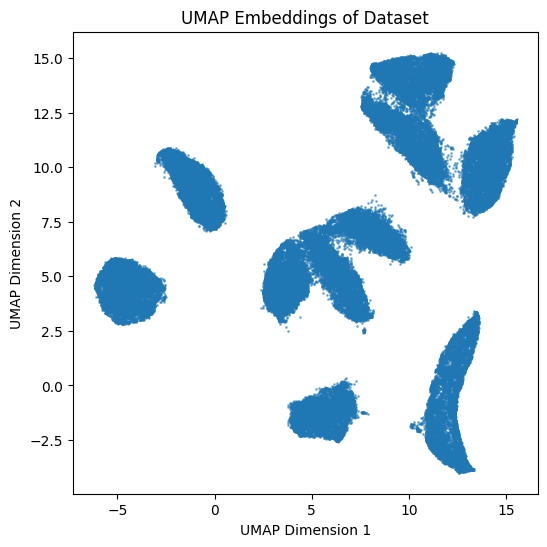

In [7]:
# Plot embeddings
plt.figure(figsize=(6, 6))
plt.scatter(full_embeddings[:, 0], full_embeddings[:, 1], s=1, alpha=0.5)
plt.title("UMAP Embeddings of Dataset")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()


# Train Autoencoders

## Train & Test split

In [8]:
# Datasets
flat_train_images = train_images.reshape(train_images.shape[0], -1)
flat_test_images = test_images.reshape(test_images.shape[0], -1)

train_embeddings = full_embeddings[: len(train_images)]
test_embeddings = full_embeddings[len(train_images) :]

flat_train_dataset = UMAPImageDataset(
    images=flat_train_images, umap_embeddings=train_embeddings
)
flat_test_dataset = UMAPImageDataset(
    images=flat_test_images, umap_embeddings=test_embeddings
)

flat_train_loader = torch.utils.data.DataLoader(
    flat_train_dataset, batch_size=128, shuffle=False
)
flat_test_loader = torch.utils.data.DataLoader(
    flat_test_dataset, batch_size=128, shuffle=False
)

## Train normal Autoencoder

In [15]:
autoencoder_input_dim = flat_full_images.shape[1]
normal_autoencoder = MNISTAutoencoder(
    input_dim=autoencoder_input_dim, embedding_dim=embedding_dim
)
normal_criterion = torch.nn.MSELoss()
normal_optimizer = torch.optim.Adam(normal_autoencoder.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device)

normal_num_epochs = 50

train_autoencoder(
    model=normal_autoencoder,
    dataloader=flat_train_loader,
    criterion=normal_criterion,
    optimizer=normal_optimizer,
    num_epochs=normal_num_epochs,
    device=device,
)

Epoch [1/50], Loss: 0.0556
Epoch [2/50], Loss: 0.0448
Epoch [3/50], Loss: 0.0425
Epoch [4/50], Loss: 0.0413
Epoch [5/50], Loss: 0.0405
Epoch [6/50], Loss: 0.0397
Epoch [7/50], Loss: 0.0393
Epoch [8/50], Loss: 0.0390
Epoch [9/50], Loss: 0.0386
Epoch [10/50], Loss: 0.0382
Epoch [11/50], Loss: 0.0379
Epoch [12/50], Loss: 0.0376
Epoch [13/50], Loss: 0.0373
Epoch [14/50], Loss: 0.0370
Epoch [15/50], Loss: 0.0368
Epoch [16/50], Loss: 0.0369
Epoch [17/50], Loss: 0.0366
Epoch [18/50], Loss: 0.0363
Epoch [19/50], Loss: 0.0361
Epoch [20/50], Loss: 0.0360
Epoch [21/50], Loss: 0.0359
Epoch [22/50], Loss: 0.0357
Epoch [23/50], Loss: 0.0354
Epoch [24/50], Loss: 0.0353
Epoch [25/50], Loss: 0.0352
Epoch [26/50], Loss: 0.0350
Epoch [27/50], Loss: 0.0350
Epoch [28/50], Loss: 0.0349
Epoch [29/50], Loss: 0.0351
Epoch [30/50], Loss: 0.0353
Epoch [31/50], Loss: 0.0353
Epoch [32/50], Loss: 0.0347
Epoch [33/50], Loss: 0.0352
Epoch [34/50], Loss: 0.0345
Epoch [35/50], Loss: 0.0344
Epoch [36/50], Loss: 0.0346
E

## Train Autoencoder with UMAP as teacher

In [16]:
autoencoder_input_dim = flat_full_images.shape[1]
umap_autoencoder = MNISTAutoencoder(
    input_dim=autoencoder_input_dim, embedding_dim=embedding_dim
)

umap_criterion = UMAPAutoencoderLoss(reconstruction_weight=0.5, umap_weight=0.5)
umap_optimizer = torch.optim.Adam(umap_autoencoder.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device)

umap_num_epochs = 50

train_autoencoder_with_umap(
    model=umap_autoencoder,
    dataloader=flat_train_loader,
    criterion=umap_criterion,
    optimizer=umap_optimizer,
    num_epochs=umap_num_epochs,
    device=device,
)


Epoch [1/50], Loss: 3.2885
Epoch [2/50], Loss: 0.9085
Epoch [3/50], Loss: 0.6119
Epoch [4/50], Loss: 0.4781
Epoch [5/50], Loss: 0.3875
Epoch [6/50], Loss: 0.3216
Epoch [7/50], Loss: 0.2699
Epoch [8/50], Loss: 0.2279
Epoch [9/50], Loss: 0.1959
Epoch [10/50], Loss: 0.1709
Epoch [11/50], Loss: 0.1526
Epoch [12/50], Loss: 0.1390
Epoch [13/50], Loss: 0.1338
Epoch [14/50], Loss: 0.1367
Epoch [15/50], Loss: 0.1262
Epoch [16/50], Loss: 0.1262
Epoch [17/50], Loss: 0.1213
Epoch [18/50], Loss: 0.1070
Epoch [19/50], Loss: 0.1009
Epoch [20/50], Loss: 0.0892
Epoch [21/50], Loss: 0.0774
Epoch [22/50], Loss: 0.0740
Epoch [23/50], Loss: 0.0706
Epoch [24/50], Loss: 0.0706
Epoch [25/50], Loss: 0.0762
Epoch [26/50], Loss: 0.0717
Epoch [27/50], Loss: 0.0634
Epoch [28/50], Loss: 0.0621
Epoch [29/50], Loss: 0.0675
Epoch [30/50], Loss: 0.0742
Epoch [31/50], Loss: 0.0640
Epoch [32/50], Loss: 0.0550
Epoch [33/50], Loss: 0.0507
Epoch [34/50], Loss: 0.0519
Epoch [35/50], Loss: 0.0535
Epoch [36/50], Loss: 0.0555
E

# Compare results

## Compare image results

### Plot image reconstructions

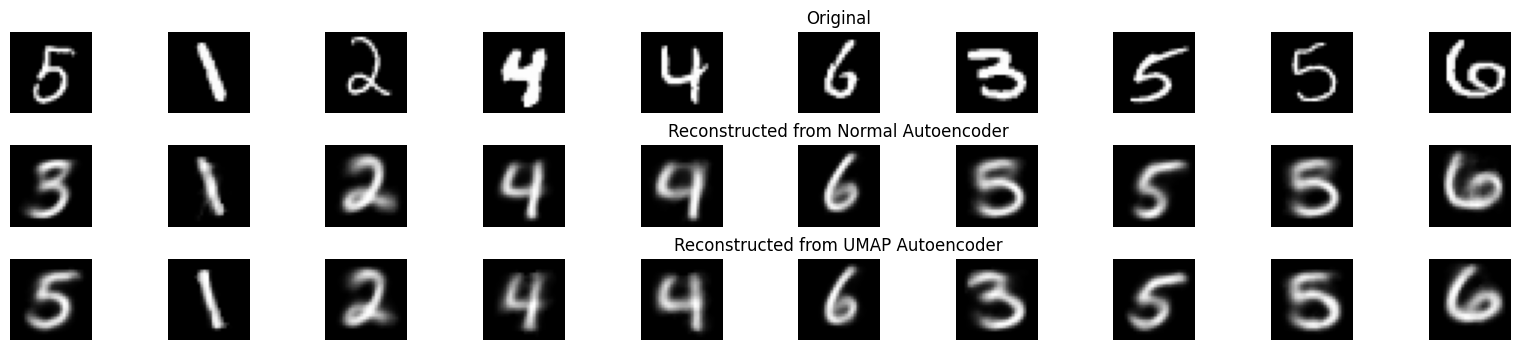

In [63]:
# Plot example image and reconstructions
normal_autoencoder.eval()
umap_autoencoder.eval()
with torch.no_grad():
    sample_images, _ = next(iter(flat_test_loader))
    sample_images = sample_images.to(device).float()

    normal_autoencoder_reconstructed = normal_autoencoder(sample_images).cpu().numpy()
    umap_autoencoder_reconstructed = umap_autoencoder(sample_images).cpu().numpy()

    sample_images = sample_images.cpu().numpy()
    n = 10

    fig, ax = plt.subplots(3, n, figsize=(20, 4))
for i in range(n):
    # Original
    ax[0, i].imshow(test_images[45 + i].reshape(28, 28), cmap="gray")
    ax[0, i].axis("off")

    # Reconstructed from Normal autoencoder
    ax[1, i].imshow(
        normal_autoencoder_reconstructed[45 + i].reshape(28, 28), cmap="gray"
    )
    ax[1, i].axis("off")

    # Reconstructed from UMAP autoencoder
    ax[2, i].imshow(umap_autoencoder_reconstructed[45 + i].reshape(28, 28), cmap="gray")
    ax[2, i].axis("off")

# Set titles
ax[0, 5].set_title("Original")
ax[1, 5].set_title("Reconstructed from Normal Autoencoder")
ax[2, 5].set_title("Reconstructed from UMAP Autoencoder")
plt.subplots_adjust(hspace=0.4)
plt.show()

## Compare Metrics

In [33]:
# Test
normal_reconstruction_loss = test_autoencoder_reconstruction(
    normal_autoencoder, flat_test_loader, device
)
umap_reconstruction_loss = test_autoencoder_reconstruction(
    umap_autoencoder, flat_test_loader, device
)

print(f"Normal Autoencoder Reconstruction Loss: {normal_reconstruction_loss:.4f}")
print(f"UMAP Autoencoder Reconstruction Loss: {umap_reconstruction_loss:.4f}")

Normal Autoencoder Reconstruction Loss: 0.0354
UMAP Autoencoder Reconstruction Loss: 0.0386


In [34]:
normal_umap_embedding_loss = test_autoencoder_umap_embedding(
    normal_autoencoder, flat_test_loader, device
)
umap_umap_embedding_loss = test_autoencoder_umap_embedding(
    umap_autoencoder, flat_test_loader, device
)

print(f"Normal Autoencoder UMAP Embedding Loss: {normal_umap_embedding_loss:.4f}")
print(f"UMAP Autoencoder UMAP Embedding Loss: {umap_umap_embedding_loss:.4f}")

Normal Autoencoder UMAP Embedding Loss: 195.1749
UMAP Autoencoder UMAP Embedding Loss: 0.6697


## Compare latent spaces

### Normal Autoencoder latent space

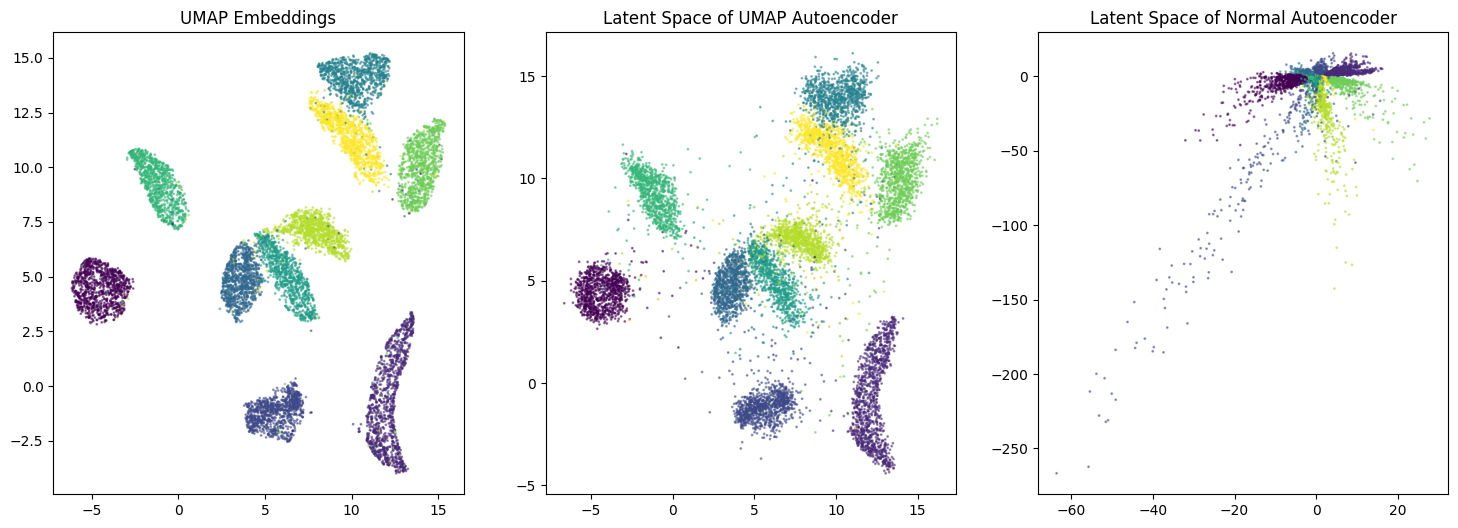

In [44]:
normal_autoencoder.eval()
umap_autoencoder.eval()

all_normal_autoencoder_latents = []
all_umap_autoencoder_latents = []
with torch.no_grad():
    for images, _ in flat_test_loader:
        images = images.to(device).float()

        normal_autoencoder_latents = normal_autoencoder.encoder(images).cpu().numpy()
        umap_autoencoder_latents = umap_autoencoder.encoder(images).cpu().numpy()

        all_normal_autoencoder_latents.append(normal_autoencoder_latents)
        all_umap_autoencoder_latents.append(umap_autoencoder_latents)

all_normal_autoencoder_latents = np.concatenate(all_normal_autoencoder_latents, axis=0)
all_umap_autoencoder_latents = np.concatenate(all_umap_autoencoder_latents, axis=0)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
colors = test_labels.argmax(axis=1)


ax[0].scatter(
    test_embeddings[:, 0],
    test_embeddings[:, 1],
    s=1,
    alpha=0.5,
    c=colors,
    label="UMAP Embeddings",
)

ax[1].scatter(
    all_umap_autoencoder_latents[:, 0],
    all_umap_autoencoder_latents[:, 1],
    s=1,
    alpha=0.5,
    c=colors,
    label="UMAP Autoencoder",
)

ax[2].scatter(
    all_normal_autoencoder_latents[:, 0],
    all_normal_autoencoder_latents[:, 1],
    s=1,
    alpha=0.5,
    c=colors,
    label="Normal Autoencoder",
)

ax[0].set_title("UMAP Embeddings")
ax[1].set_title("Latent Space of UMAP Autoencoder")
ax[2].set_title("Latent Space of Normal Autoencoder")

plt.show()


# Recreate images from UMAP embedding

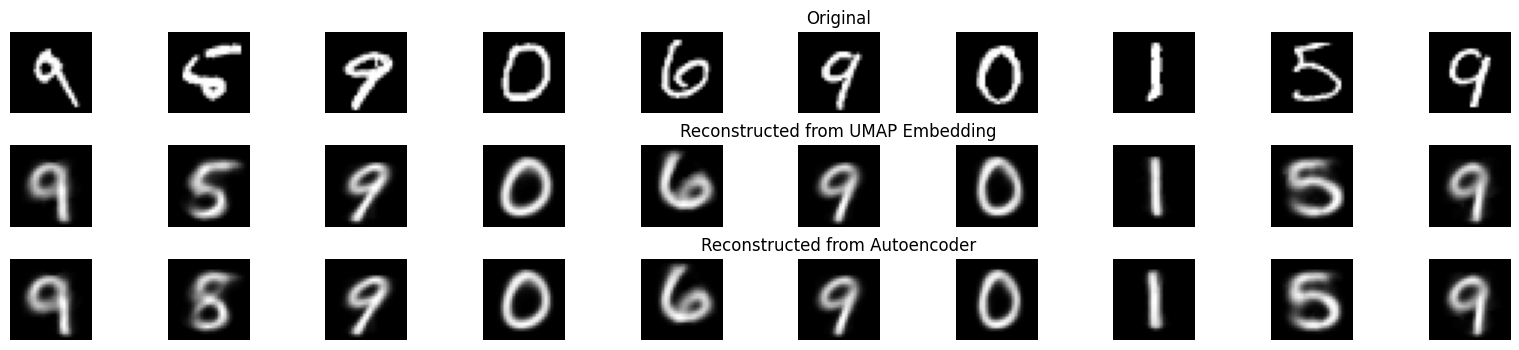

In [75]:
# pass all test UMAP embeddings through the UMAP decoder
reconstructed_test_images = (
    umap_autoencoder.decoder(
        torch.tensor(test_embeddings, dtype=torch.float32).to(device)
    )
    .cpu()
    .detach()
    .numpy()
)

umap_autoencoder.eval()
with torch.no_grad():
    sample_images, _ = next(iter(flat_test_loader))
    sample_images = sample_images.to(device).float()

    umap_autoencoder_reconstructed = umap_autoencoder(sample_images).cpu().numpy()

    sample_images = sample_images.cpu().numpy()

# Plot some reconstructed images from UMAP embeddings
n = 10
fig, ax = plt.subplots(3, n, figsize=(20, 4))
for i in range(n):
    # Original
    ax[0, i].imshow(test_images[7 + i].reshape(28, 28), cmap="gray")
    ax[0, i].axis("off")

    # Reconstructed from UMAP embedding
    ax[1, i].imshow(reconstructed_test_images[7 + i].reshape(28, 28), cmap="gray")
    ax[1, i].axis("off")

    # Reconstructed from autoencoder
    ax[2, i].imshow(umap_autoencoder_reconstructed[7 + i].reshape(28, 28), cmap="gray")
    ax[2, i].axis("off")

# Set titles
ax[0, 5].set_title("Original")
ax[1, 5].set_title("Reconstructed from UMAP Embedding")
ax[2, 5].set_title("Reconstructed from Autoencoder")
plt.subplots_adjust(hspace=0.4)
plt.show()

# Speed vs UMAP

In [76]:
# Test speed of real UMAP vs UMAP autoencoder's encoder (they do the same thing essentially)
import time

start_time = time.time()
test_embeddings = reducer.transform(flat_test_images)
umap_time = time.time() - start_time
print(f"UMAP transform time: {umap_time:.4f} seconds")

start_time = time.time()
test_embeddings_ae = umap_autoencoder.encoder(
    torch.tensor(flat_test_images, dtype=torch.float32).to(device)
)
umap_autoencoder_time = time.time() - start_time
print(f"UMAP Autoencoder encoder time: {umap_autoencoder_time:.4f} seconds")

UMAP transform time: 2.0220 seconds
UMAP Autoencoder encoder time: 0.1456 seconds
